In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
from itertools import product
from models import GNNClassifier, GNNSim
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import os

In [3]:
# import util
# graphs, _ = util.load_data("MUTAG", degree_as_tag=False)

In [4]:
random_state = 1
batch_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_state)
# torch.cuda.manual_seed(random_state)
np.random.seed(random_state)

path = os.path.join('./', 'data', 'TU')
# dataset = TUDataset(path, name='MUTAG').shuffle()
dataset = TUDataset(path, name='MUTAG')
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

M = 10
dataloader = DataLoader(dataset[:M], batch_size=1, shuffle=False)

/Users/k/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
import networkx as nx
from util import S2VGraph

def map_dataloader_to_graphs(dataloader):
    graphs = []
    for data in dataloader:
        g = nx.Graph()
        label = data.y
        node_tags = None
        # add node
        for j in range(data.x.shape[0]):
            g.add_node(j)
        # add edge
        for i in range(data.edge_index.shape[-1]):
            node_a, node_b = data.edge_index[0][i].item(), data.edge_index[1][i].item()
            g.add_edge(node_a, node_b)
        s2v_graph = S2VGraph(g, label, node_tags)
        s2v_graph.node_features = data.x
        graphs.append(s2v_graph)
    
    
    for g in graphs:
        g.neighbors = [[] for i in range(len(g.g))]
        for i, j in g.g.edges():
            g.neighbors[i].append(j)
            g.neighbors[j].append(i)
        degree_list = []
        for i in range(len(g.g)):
            g.neighbors[i] = g.neighbors[i]
            degree_list.append(len(g.neighbors[i]))
        g.max_neighbor = max(degree_list)

    return graphs


graphs = map_dataloader_to_graphs(dataloader)

In [6]:
from kernels import GNTK
import scipy

def calculate_inf_ntk(graphs):
    # calculate theortical gntk
    gntk = GNTK(num_layers=2, num_mlp_layers=1, jk=0, scale="uniform")
    A_list = []
    diag_list = []

    # procesing the data
    for i in range(len(graphs)):
        n = len(graphs[i].neighbors)
        for j in range(n):
            graphs[i].neighbors[j].append(j)
        edges = graphs[i].g.edges
        m = len(edges)

        row = [e[0] for e in edges]
        col = [e[1] for e in edges]
        A_list.append(scipy.sparse.coo_matrix(([1] * len(edges), (row, col)), shape = (n, n), dtype = np.float32))
        A_list[-1] = A_list[-1] + A_list[-1].T + scipy.sparse.identity(n)
        diag = gntk.diag(graphs[i], A_list[i])
        diag_list.append(diag)


    def calc(T):
        return gntk.gntk(graphs[T[0]], graphs[T[1]], diag_list[T[0]], diag_list[T[1]], A_list[T[0]], A_list[T[1]])

    gram = np.zeros((len(graphs), len(graphs)))
    graphs_pair = [(i, j) for i in range(len(graphs)) for j in range(i, len(graphs))]

    for pair in graphs_pair:
        result = calc(pair)
        gram[pair[0], pair[1]] = result
        gram[pair[1], pair[0]] = result
    
    return gram

gram = calculate_inf_ntk(graphs)

[[ 9063.01307754  5814.13481702  5814.13481702 10576.35085233
   4063.76650834]
 [ 5814.13481702  3835.40711251  3835.40711251  6770.02879059
   2668.6552912 ]
 [ 5814.13481702  3835.40711251  3835.40711251  6770.02879059
   2668.6552912 ]
 [10576.35085233  6770.02879059  6770.02879059 12345.68862713
   4729.81217043]
 [ 4063.76650834  2668.6552912   2668.6552912   4729.81217043
   1953.79810988]]


In [7]:
def clone_grads(net):
    d = {}
    for name, p in net.named_parameters():
        if p.grad is not None:
            d[name] = p.grad.clone().detach()
    return d

def paramdot(d1, d2):
    return sum(
        torch.dot(d1[k].reshape(-1), d2[k].reshape(-1))
        for k in d1)
def normalize_matrix(matrix):
    m = np.max(matrix)
    out = matrix / m
    return out

In [8]:
model_config = {}
model_config["input_dim"] = 7
model_config["hidden_dim"] = 32
model_config["output_dim"] = 32
model_config["n_class"] = 2
model_config["c_u"] = 1
model_config["c_sigma"] = 2
model_config["num_layers"] = 2
learning_rate = 0.001
epochs = 100

In [14]:
nseeds = 100
log2_width_min = 2
log2_width_max = 12
widths = 2**np.arange(log2_width_min, log2_width_max)

M = len(dataloader)
inf_ntk = gram

inf_ntk_norm = np.linalg.norm(inf_ntk)
inf_ntk_normalize = normalize_matrix(inf_ntk)


frobs = []

for width, seed in tqdm(list(product(widths, range(nseeds)))):
    torch.manual_seed(seed)
    model_config["hidden_dim"] = model_config["output_dim"] = width
    model = GNNSim(model_config)
    grads = []
    
    for graph in dataloader:
        model.zero_grad()
        loss = model(graph)
        loss.backward()
        grads.append(clone_grads(model))
    
    finite_ntk = np.zeros((M,M))
    for i in range(M):
        for j in range(i+1):
            finite_ntk[i, j] = finite_ntk[j, i] = paramdot(grads[i], grads[j])
    
    finite_ntk_normalize = normalize_matrix(finite_ntk)
    
    frobs.append(dict(
        width = width, 
        finite_ntk = finite_ntk_normalize ,
        relfrob=np.linalg.norm(finite_ntk_normalize-inf_ntk_normalize)/inf_ntk_norm))

frob_df = pd.DataFrame(frobs) 


  6%|██▏                                     | 55/1000 [00:00<00:07, 131.21it/s]/var/folders/qh/3jndncm93jb1gybw7l3jf2p80000gn/T/ipykernel_20772/2441349998.py:14: RuntimeWarning: invalid value encountered in true_divide
  out = matrix / m
100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.14it/s]


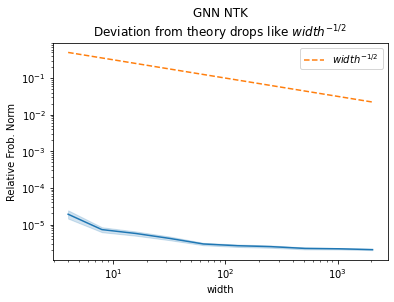

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=frob_df, x='width', y='relfrob')
widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
# plt.xscale('log')
plt.legend()
_ = plt.title(u'GNN NTK\nDeviation from theory drops like $width^{-1/2}$')

In [11]:
a = torch.Tensor([1,2,3,4,5])
torch.sum(a)


tensor(15.)